In [400]:
import math
import numpy as np
import pandas as pd
from scipy.optimize import minimize




reload_data = False



#
# This takes a moment
#
if reload_data:
    prefs     = pd.read_csv( './data/sfusd-2017-2018-prefs.csv' )
    schools   = pd.read_csv( './data/sfusd-2017-2018-schools.csv' )
    zip_codes = pd.read_csv( './data/zip-code-centroids-2016.csv' )

    for p in range( 1, 93 ):
        for s in range( len( schools['School #'] ) ):
            continue
            prefs[str( p )].replace( schools['School #'][s], schools['School Name'][s], inplace = True )
            
    for s in range( len( schools['School #'] ) ):
        prefs['Round 1 Assignment'].replace( schools['School #'][s], schools['School Name'][s], inplace = True )


In [401]:
import json
import re
import requests
from lxml import html

page = requests.get( 'https://www.sfusd.edu/schools/enroll/discover/school-finder' )
tree = html.fromstring( page.content )

# wrap all of this in an error checker
school_data_string = tree.xpath( '//script[@data-drupal-selector]/text()' )[0]
school_data        = json.loads( school_data_string )['schoolFinder']['schoolData']
school_data        = json.loads( school_data )

In [402]:
schools = []
for i in range( len( school_data ) ):
    school = school_data[i]
    
    school_address   = school['address']
    school_id        = school['code_number']
    school_type      = school['type'].split( r',' )
    school_name      = html.fromstring( school['title'] ).xpath( '//a/text()' )[0]
    school_grade     = school['field_grade_level']
    school_latitude  = float( school['field_latitude'] ) if school['field_latitude'] else 0
    school_longitude = float( school['field_longitude'] ) if school['field_longitude'] else 0
    school_cdscode   = school['field_accountability_dashboard']
    
    #
    # Correct the school id
    #
    if len( school_id ):
        school_id_match = re.match( '^\s*(\d+)', school_id )
        if not school_id_match:
            print( 'ERROR WITH SCHOOL ID \'%s\'' % school_id )
            continue
        
        school_id = int( school_id_match.group( 1 ) )
        
    else:
        print( 'ERROR WITH SCHOOL \'%s\' (no school id)' % school_name )
        continue
        
    #
    # Check the CDSCODE
    #
    if len( school_cdscode ):
        school_cdscode_match = re.search( '(?<=\\/)\\d{14}', school_cdscode )
        if not school_cdscode_match:
            print( 'ERROR WITH SCHOOL CDSCODE \'%s\' (id %d)' % ( school_cdscode, school_id ) )
            continue
            
        school_cdscode = school_cdscode_match.group( 0 )
        
    elif school_id not in [ 796 ]:
        print( 'ERROR WITH SCHOOL \'%s\' (id %d) (no CDSCODE)' % ( school_name, school_id ) )
        continue
    
    #print( '%03d: %s' % ( school_id, school_name ) )
    
    schools.append( {
        'address':   school_address,
        'cdscode':   school_cdscode,
        'id':        school_id,
        'type':      school_type,
        'name':      school_name,
        'grade':     school_grade,
        'latitude':  school_latitude,
        'longitude': school_longitude
    })
    
#
# Augment later with quality metrics, etc.
#
# NOTE. Rooftop has two campuses, but only one for Kindergarten. (https://www.sfusd.edu/school/rooftop-school-pk-8)
# NOTE. Claire Lillenthal has two campuses, but only one for Kindergarten.
#
school_df = pd.DataFrame( schools )

rooftop_cdscode = max( school_df[school_df['id'] == 796]['cdscode'] )
school_df.loc[school_df['id'] == 796,'cdscode'] = rooftop_cdscode
school_df = school_df[( school_df['id'] != 796 ) | ( ~school_df['name'].str.contains( 'Mayeda' ) )]

school_df = school_df[( school_df['id'] != 479 ) | ( school_df['name'].str.contains( 'Madison' ) )]

# Check the data...
#school_id_counts = school_df.groupby( 'id' )['name'].count()
#school_id_counts[school_id_counts > 1]

ERROR WITH SCHOOL 'Argonne Early Education School' (id 903) (no CDSCODE)
ERROR WITH SCHOOL 'Commodore Stockton Early Education School' (id 915) (no CDSCODE)
ERROR WITH SCHOOL 'Downtown High School' (id 742) (no CDSCODE)
ERROR WITH SCHOOL 'Ida B. Wells High School' (id 743) (no CDSCODE)
ERROR WITH SCHOOL 'Independence High School' (id 466) (no CDSCODE)
ERROR WITH SCHOOL 'Jefferson Early Education School' (id 948) (no CDSCODE)
ERROR WITH SCHOOL 'John McLaren Early Education School' (no school id)
ERROR WITH SCHOOL 'Junipero Serra Annex Early Education School' (no school id)
ERROR WITH SCHOOL 'Leola M. Havard Early Education School' (no school id)
ERROR WITH SCHOOL 'Noriega Early Education School' (id 928) (no CDSCODE)
ERROR WITH SCHOOL 'Online Learning Program' (no school id)
ERROR WITH SCHOOL 'Presidio Early Education School' (no school id)
ERROR WITH SCHOOL 'Raphael Weill Early Education School' (no school id)
ERROR WITH SCHOOL 'San Miguel Early Education School' (no school id)
ERROR W

In [403]:
min_applications = 13 # by eyeballing
zip_counts       = prefs.groupby( 'Student\'s Residential Zip Code' )['StudentNo'].count()
zip_counts       = zip_counts[zip_counts >= min_applications]
student_zips     = list( zip_counts.to_dict() )



#
# Approximate distance. We're working in the city, and we've already assumed ZIP centroids. If we care about
# a better distance estimate, we should use Google driving directions (or something). This is a reasonable approxmation.
#
deg_to_km = 110.25
def distance_in_miles ( lat1, lng1, lat2, lng2 ):
    dx = ( lng2 - lng1 ) * math.cos( lat1 )
    dy = lat2 - lat1
    
    return deg_to_km * math.sqrt( dx ** 2 + dy ** 2 )



#
# This won't work for 00xxx zip codes, because Python stripped leading zeroes. Not an issue because we're in SF.
#
for zip_code in student_zips:
    zip_location = zip_codes[zip_codes['zcta5'] == zip_code]
    school_df['dist_%s' % zip_code] = [ distance_in_miles( zip_location['intptlat'].iloc[0], zip_location['intptlong'].iloc[0], school_lat, school_lng ) for school_lat, school_lng in zip( school_df['latitude'], school_df['longitude'] ) ]

In [404]:
#
# Now we need to filter down the list of schools so that logit can work its magic
#
schools_applied = set()

for colname in prefs.columns:
    if not re.match( '^\d+', colname ):
        continue
        
    ranked_schools = prefs[colname]
    ranked_schools = ranked_schools[~np.isnan( ranked_schools )]
    ranked_schools = [ int( school_id ) for school_id in ranked_schools ]
    
    schools_applied.update( ranked_schools )
    
school_df = school_df[school_df['id'].isin( schools_applied )]

In [405]:
#
# Now move family preferences to a vector
#

pref_indexes = []
pref_index   = 1

while True:
    if str( pref_index ) not in prefs:
        break
        
    pref_indexes.append( str( pref_index ) )
    pref_index += 1
    


def reduce_preferences_to_vector ( row ):
    pref_vector = []
    
    for pref_index in pref_indexes:
        pref = row[pref_index]
        
        if np.isnan( pref ):
            break
            
        #
        # We'll take a stance here: if you list X at position k and also at position k' > k, you like it at k
        # (row 1 has duplicate preferences listed; others probably do, too)
        #
        pref = int( pref )
        if pref not in pref_vector:
            pref_vector.append( pref )
        
    # pref_vector.append( 0 )
    return pref_vector



prefs_for_analysis                = pd.DataFrame()
prefs_for_analysis['pref_vector'] = prefs.apply( reduce_preferences_to_vector, axis = 1 )

In [406]:
#
# Now that we've got preferences encoded as a vector, augment data with unranked schools, then augment again with distances
#
prefs_for_analysis['zip']      = prefs['Student\'s Residential Zip Code']
prefs_for_analysis             = prefs_for_analysis[prefs_for_analysis['zip'].isin( student_zips )]
prefs_for_analysis['unranked'] = prefs_for_analysis.apply( lambda row: list( schools_applied - set( row['pref_vector'] ) ), axis = 1 )

In [407]:
#
# Doing some caching
#
school_df       = school_df.set_index( 'id' )
school_df['id'] = school_df.index



#
# Note that this block takes awhile (all the pivoting/lookups). It saves the data to JSON at the bottom, just load it directly when necessary
#
def ranking_to_distance ( row, label ):
    distances = [ None ] * len( row[label] )
    row_prefs = row[label]
    zip_code  = row['zip']
    dist_code = 'dist_%d' % zip_code
    
    for i in range( len( distances ) ):
        school_id = row_prefs[i]
        if school_id < 1: # this should never hold
            continue
            
        distances[i] = school_df.loc[school_id,dist_code]
        
    return distances



#
# Breaking this over multiple lines was not the solution...
#
distance_ranked   = prefs_for_analysis.apply( lambda row: ranking_to_distance( row, 'pref_vector' ), axis = 1 )
distance_unranked = prefs_for_analysis.apply( lambda row: ranking_to_distance( row, 'unranked' ), axis = 1 )

# Be sure to drop the terminal `None` in the ranked preferences
prefs_for_analysis['distance_ranked']   = distance_ranked.apply( lambda row: np.array( row ) ) # if we None-pad the end again, need to do row[:-1]
prefs_for_analysis['distance_unranked'] = distance_unranked.apply( lambda row: np.array( row ) )
prefs_for_analysis.to_json( './prefs_for_analysis.json' )

In [408]:
#
# Add extra data to schools; additional files may be found here: https://www.cde.ca.gov/ta/ac/sa/accessdata1920.asp
#
# Note that the file format changes from { 1718, 1819 } to { 1920 }: we move from district codes to district names
#
# (these values should be cleaned up)
#
SFUSD_code = 68478
SFUSD_name = 'San Francisco Unified'

data_source = '1718'

filter_column_name  = 'District Code'
filter_column_value = SFUSD_code

if data_source in [ '1920' ]:
    filter_column_name  = 'DISTRICT'
    filter_column_value = SFUSD_name

CA_sarc_data = pd.read_csv( './data/caall-%s.txt' % data_source )
CA_sarc_data = CA_sarc_data[CA_sarc_data[filter_column_name] == filter_column_value]



#
# Add some basic test score data
#
school_df['cdscode'] = school_df['cdscode'].astype( 'int64' )
school_df            = school_df.merge( CA_sarc_data[['CDS','SELA_Y1','SMATH_Y1']], left_on = 'cdscode', right_on = 'CDS' )

In [288]:
#
# This is old code. It will work fine.
#
def log_likelihood ( beta, outside, row ):
    sum_exp_unranked = sum( np.exp( row['distance_unranked'] * beta ) ) #[ v * beta for v in row['distance_unranked'] ] ) )
    tail_sum         = math.exp( outside ) + sum_exp_unranked
    
    beta_ranked     = row['distance_ranked'] * beta # [ v * beta for v in row['distance_ranked'][:-1] ]
    exp_beta_ranked = np.exp( beta_ranked )
    
    log_denominators = np.log( [ sum( exp_beta_ranked[i:] ) + tail_sum for i in range( len( beta_ranked ) ) ] )
    
    return ( sum( beta_ranked ) + outside ) - ( sum( log_denominators ) + np.log( tail_sum ) )



def objective ( params ):
    return -sum( prefs_for_analysis.apply( lambda row: log_likelihood( params[0], params[1], row ), axis = 1 ) )
    
    
    
#log_likelihood( 0, 0, prefs_for_analysis.iloc[0] ) #prefs_for_analysis.iloc[0]['distance_unranked'] #distance_ranked[2] #objective( -0.05, -2 )

In [481]:
#
# Pre-separate some data for regression
#
df_distances  = pd.DataFrame( school_df[school_df.columns[school_df.columns.str.contains( 'dist_' )]] )
df_score_ela  = pd.DataFrame( school_df[['id','SELA_Y1']] )
df_score_math = pd.DataFrame( school_df[['id','SMATH_Y1']] )

df_score_ela['SELA_Y1']   = df_score_ela['SELA_Y1'].apply( lambda x: int( float( x ) ) )
df_score_math['SMATH_Y1'] = df_score_math['SMATH_Y1'].apply( lambda x: int( float( x ) ) )

df_distances['id'] = list( school_df['id'] )
df_distances.set_index( 'id', inplace = True )
df_score_ela.set_index( 'id', inplace = True )
df_score_math.set_index( 'id', inplace = True )



def log_likelihood ( wg, outside, row ):
    zip_label = 'dist_%s' % row['zip']
    
    prefs_ranked   = row['pref_vector']
    prefs_unranked = row['unranked']
    
    val_unranked = np.array( [ wg[0].loc[sid,zip_label] + wg[1].loc[sid,'SELA_Y1'] + wg[2].loc[sid,'SMATH_Y1'] for sid in row['unranked'] ] )#i in range( len( prefs_ranked ) ) ] )#sid in row['unranked'] ] )
    val_ranked   = np.array( [ wg[0].loc[sid,zip_label] + wg[1].loc[sid,'SELA_Y1'] + wg[2].loc[sid,'SMATH_Y1'] for sid in row['pref_vector'] ] )
    
    exp_val_ranked = np.exp( val_ranked )
    
    tail_sum         = math.exp( outside ) + sum( np.exp( val_unranked ) )
    log_denominators = np.log( [ sum( exp_val_ranked[i:] ) + tail_sum for i in range( len( val_ranked ) ) ] )
    
    return ( sum( val_ranked ) + outside ) - ( sum( log_denominators ) + np.log( tail_sum ) )



def objective ( params ):
    param_distance   = params[0]
    param_score_ela  = params[1]
    param_score_math = params[2]
    
    wg_distances  = df_distances * param_distance
    wg_score_ela  = df_score_ela * param_score_ela
    wg_score_math = df_score_math * param_score_math
    
    return -sum( prefs_for_analysis.apply(
        lambda row: log_likelihood( ( wg_distances, wg_score_ela, wg_score_math ), params[3], row ),
        axis = 1
    ) )




In [482]:
param_names = [ 'distance', 'score_ela', 'score_math', 'outside_option' ]
res = minimize( lambda params: objective( params ), [ 0 ] * len( param_names ) )

In [483]:
res

      fun: 173638.39322970135
 hess_inv: array([[ 2.67798939e-06, -3.16265385e-07,  1.52007877e-07,
        -4.29235824e-06],
       [-3.16265385e-07,  7.65448364e-07, -7.13789019e-07,
        -2.44757172e-08],
       [ 1.52007877e-07, -7.13789019e-07,  7.05328388e-07,
         2.26432098e-07],
       [-4.29235824e-06, -2.44757172e-08,  2.26432098e-07,
         7.95721572e-06]])
      jac: array([ 0.01171875,  0.0234375 , -0.00976562,  0.015625  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 179
      nit: 14
     njev: 35
   status: 2
  success: False
        x: array([-0.29594153,  0.04482865, -0.00461972,  2.12372021])

In [485]:
#school_df[school_df['name'].str.contains( 'Park' )]

school_df.to_json( './sfusd-schools-filtered.json' )

In [486]:
#
# How many prefs have an error?
#
len( prefs )



def count_pref_errors ( row ):
    pref_vector = []
    
    for pref_index in pref_indexes:
        pref = row[pref_index]
        
        if np.isnan( pref ):
            return False
            
        #
        # We'll take a stance here: if you list X at position k and also at position k' > k, you like it at k
        # (row 1 has duplicate preferences listed; others probably do, too)
        #
        pref = int( pref )
        if pref in pref_vector:
            return True
        
        pref_vector.append( pref )
            
    return False



pref_error_status = prefs.apply( count_pref_errors, axis = 1 )
print( '{} of {} ({:0.2%}) submitted preference profiles contain an error.'.format( sum( pref_error_status ), len( prefs ), sum( pref_error_status ) / len( prefs ) ) )

1647 of 4611 (35.72%) submitted preference profiles contain an error.


In [487]:
math.exp(2.12)/(math.exp(2.12)+math.exp(3.05))

0.28292471450702755

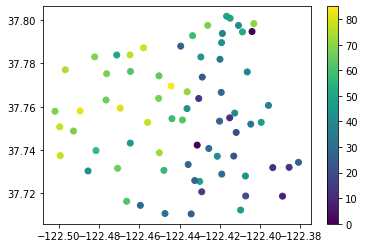

In [508]:
#import plotly.express as plex
#plex.scatter_geo( school_df, lat = 'latitude', lon = 'longitude' )

import matplotlib.pyplot as plot

fig, axes = plot.subplots()

school_lls = axes.scatter( school_df['longitude'], school_df['latitude'], c = df_score_ela['SELA_Y1'], cmap = 'viridis' ) #sizes = df_score_ela['SELA_Y1'] )
fig.colorbar( school_lls )

In [501]:
scores_df = pd.DataFrame( { 'ela': df_score_ela['SELA_Y1'], 'math': df_score_math['SMATH_Y1'] } )
scores_df.corr()

,ela,math
ela,1.000000,0.960858
math,0.960858,1.000000
